In [1]:
""" 
SOAR Offline Laptime Optimization for Reference Trajectory Generation
AA 203/273 Spring 2024
Andrew Wang, Bryan Yang
"""
import numpy as np
from pyomo.environ import *
from pyomo.dae import *
import matplotlib.pyplot as plt
from agents import BicycleVehicle
from config import *

In [2]:
%load_ext autoreload
%autoreload 2

# L Track Optimization

In [3]:
# Set up L track for optimization
L_veh_config = get_vehicle_config()
L_scene_config = get_scene_config(track_type=L_TRACK)
L_veh_constraints = get_vehicle_opt_constraints(L_veh_config, L_scene_config)
L_track = L_scene_config["track"]

Track Closure Error [-1.10242584e-02 -9.63282770e-02  3.63865760e-09]


In [4]:
print(L_track.name)

L TRACK w/Straight 1000, Curve Radius 500


In [5]:
def plot_racelines(track, raceline):
    import matplotlib.pyplot as plt
    import os

    fig_xy = plt.figure(figsize=(20, 20))
    ax = fig_xy.gca()
    track.plotTrack(ax)

    fig_ts = plt.figure(figsize=(50, 30))
    ax_s = fig_ts.add_subplot(10, 1, 1)
    ax_s.set_ylabel('s')
    ax_ey = fig_ts.add_subplot(10, 1, 2)
    ax_ey.set_ylabel('ey')
    ax_ep = fig_ts.add_subplot(10, 1, 3)
    ax_ep.set_ylabel('epsi')
    ax_vx = fig_ts.add_subplot(10, 1, 4)
    ax_vx.set_ylabel('vx')
    ax_vy = fig_ts.add_subplot(10, 1, 5)
    ax_vy.set_ylabel('vy')
    ax_om = fig_ts.add_subplot(10, 1, 6)
    ax_om.set_ylabel('omega')
    ax_delta = fig_ts.add_subplot(10, 1, 7)
    ax_delta.set_ylabel('delta')
    ax_ua = fig_ts.add_subplot(10, 1, 8)
    ax_ua.set_ylabel('u_accel')
    ax_us = fig_ts.add_subplot(10, 1, 9)
    ax_us.set_ylabel('u_steer (ddelta)')
    ax_us.set_xlabel('t [s]')

    speed = np.sqrt(np.power(raceline['v_long'],2)+np.power(raceline['v_tran'],2))
    sc = ax.scatter(raceline['x'], raceline['y'], c=speed)
    ax.plot(raceline['x'], raceline['y'], 'b')

    ax_s.plot(raceline['t'], raceline['s'], 'b')
    ax_ey.plot(raceline['t'], raceline['e_y'], 'b')
    ax_ep.plot(raceline['t'], raceline['e_psi'], 'b')
    ax_vx.plot(raceline['t'], raceline['v_long'], 'b')
    ax_vy.plot(raceline['t'], raceline['v_tran'], 'b')
    ax_om.plot(raceline['t'], raceline['psidot'], 'b')
    ax_delta.plot(raceline['t'], raceline['delta'], 'b')
    ax_ua.plot(raceline['t'], raceline['u_a'], 'b')
    ax_us.plot(raceline['t'], raceline['u_s'], 'b')

    laptime = raceline['t'][-1]
    print(f'Lap time: {laptime}')

    ax.set_aspect('equal')
    plt.colorbar(mappable=sc, ax=ax, label="vel [m/s]")
    ax.set_title(f'time: {laptime:.2f} s')

    plt.draw()

In [6]:
def compute_raceline(track, vehicle_config, vehicle_constraints):

    #SYSTEM STATES:  vx=x[0],  vy=x[1], wz=x[2] ,e_psi=x[3], t=x[4], e_y=x[5]
    #SYSTEM INPUTS:  ax[m/s^2]=u0, steeringrate(rad/s)=u1
    #INDEPENDENT VARIABLE IS s (space)

    lf = vehicle_config["lf"]
    lr = vehicle_config["lr"]

    mass = vehicle_config["m"]
    Iz = vehicle_config["Iz"]

    c_alpha_f = vehicle_config["c"]
    c_alpha_r = vehicle_config["c"]
    
    Cd = vehicle_config["Cd"]
    SA = vehicle_config["SA"]
    C_downforce = vehicle_config["downforce_coeff"]
    rho = 1.225
    
    v_long_max = vehicle_constraints["ub_vx"]
    v_long_min = vehicle_constraints["lb_vx"]
    v_tran_max = vehicle_constraints["ub_vy"]
    v_tran_min = vehicle_constraints["lb_vy"]
    psidot_max = vehicle_constraints["ub_omega"]
    psidot_min = vehicle_constraints["lb_omega"]
    e_psi_max = vehicle_constraints["ub_epsi"]
    e_psi_min = vehicle_constraints["lb_epsi"]
    e_y_max = vehicle_constraints["ub_ey"]
    e_y_min = vehicle_constraints["lb_ey"]
    steer_max = vehicle_constraints["ub_delta"]
    steer_min = vehicle_constraints["lb_delta"]

    a_max = vehicle_config["max_accel"]
    a_min = -vehicle_config["max_accel"]
    steer_rate_max = vehicle_config["max_steer_rate"]
    steer_rate_min = -vehicle_config["max_steer_rate"]


    print('=================== Raceline computation ===================')
    print('Track name: %s' % track.name)
    print('     - length: %g m' % track.total_len)
    print('     - width: %g m' % (track.half_width*2))
    print('Vehicle configuration:')
    print('     - center of mass to front axle: %g m' % lf)
    print('     - center of mass to rear axle: %g m' % lr)
    print('     - mass: %g kg' % mass)
    print('     - yaw inertia: %g kg m^2' % Iz)
    print('     - Drag Coefficient: %g' % Cd)
    print('     - frontal area: %g m^2' % SA)
    print('Vehicle input constraints:')
    print('     - max acceleration: %g m/s^2' % a_max)
    print('     - min acceleration: %g m/s^2' % a_min)
    print('     - max steering angle: %g rad' % steer_max)
    print('     - min steering angle: %g rad' % steer_min)
    print('Vehicle state constraints:')
    print('     - max longitudinal velocity: %g m/s' % v_long_max)
    print('     - min longitudinal velocity: %g m/s' % v_long_min)
    print('     - max lateral velocity: %g m/s' % v_tran_max)
    print('     - min lateral velocity: %g m/s' % v_tran_min)
    print('     - max yaw rate: %g rad/s' % psidot_max)
    print('     - min yaw rate: %g rad/s' % psidot_min)
    print('============================================================')

    model = m = ConcreteModel()
    m.sf = Param(initialize=track.total_len)
    m.s = ContinuousSet(bounds=(0, m.sf), initialize=np.linspace(0, track.total_len, 1000))       #s

    m.u0 = Var(m.s, bounds=(a_min, a_max), initialize=0)
    m.u1 = Var(m.s, bounds=(steer_rate_min, steer_rate_max), initialize=0)
    m.alpha_f = Var(m.s, initialize=0)
    m.alpha_r = Var(m.s, initialize=0)
    m.Fyf = Var(m.s,bounds=(-mass*9.8*C_downforce, mass*9.8*C_downforce), initialize=0)
    m.Fyr = Var(m.s,bounds=(-mass*9.8*C_downforce, mass*9.8*C_downforce), initialize=0)
    m.x0 = Var(m.s, bounds=(v_long_min, v_long_max), initialize=100)  #vx
    m.x1 = Var(m.s, bounds=(v_tran_min, v_tran_max), initialize=0)    #vy
    m.x2 = Var(m.s, bounds=(psidot_min, psidot_max), initialize=0)    #omega
    m.x3 = Var(m.s, bounds=(e_psi_min, e_psi_max), initialize=0)      #epsi
    def _t_init(m, s):
        return s/track.total_len * 30
    m.x4 = Var(m.s, bounds=(0, 2000), initialize=_t_init)             #t
    m.x5 = Var(m.s, bounds=(e_y_min, e_y_max), initialize=0)          #ey
    m.x6 = Var(m.s, bounds=(steer_min, steer_max), initialize=0)      #delta

    m.dx0ds = DerivativeVar(m.x0, wrt=m.s)
    m.dx1ds = DerivativeVar(m.x1, wrt=m.s)
    m.dx2ds = DerivativeVar(m.x2, wrt=m.s)
    m.dx3ds = DerivativeVar(m.x3, wrt=m.s)
    m.dx4ds = DerivativeVar(m.x4, wrt=m.s)
    m.dx5ds = DerivativeVar(m.x5, wrt=m.s)
    m.dx6ds = DerivativeVar(m.x6, wrt=m.s)
    m.du0ds = DerivativeVar(m.u0, wrt=m.s)
    m.du1ds = DerivativeVar(m.u1, wrt=m.s)

    # to avoid divide by 0
    eps=0.000001

    #Objective function
#     m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.du1ds[i]**2 for i in m.s), sense=minimize)
#     m.obj = Objective(expr=m.x4[m.sf], sense=minimize) # + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.u1[i]**2 for i in m.s), sense=minimize)
    m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.1*sum(m.u1[i]**2 for i in m.s), sense=minimize)

    #sideslip and lateral force
    def _alphafc(m, s):
        # alpha = delta - atan((vy+lf*w)/vx)
        return m.alpha_f[s] == m.x6[s] - atan((m.x1[s] + lf * m.x2[s])/ (m.x0[s]))
    m.c4 = Constraint(m.s, rule=_alphafc)
    def _alpharc(m, s):
        # alpha = - atan((vy-lr*w)/vx)
        return m.alpha_r[s] == -atan((m.x1[s] - lr * m.x2[s])/ (m.x0[s]))
    m.c3 = Constraint(m.s, rule=_alpharc)
    
    def sdot_inv(m, s, cur):
        return (1 - cur*m.x5[s]) / (eps + m.x0[s]*cos(m.x3[s]) - m.x1[s]*sin(m.x3[s]))  
    def _Fyfc(m, s):
        return m.Fyf[s] ==  c_alpha_f * m.alpha_f[s]
    m.c2 = Constraint(m.s, rule=_Fyfc)
    def _Fyrc(m, s):
        return m.Fyr[s] ==  c_alpha_r * m.alpha_r[s]
    m.c1 = Constraint(m.s, rule=_Fyrc)

    #Differential model definition
    def _x0dot(m, s):
        cur = track.getCurvature(s)
        # dvx/ds = vxdot/sdot = (a - (Fd/m + Fyfsin(delta)/m + omega*vy)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx0ds[s] == (m.u0[s] - (m.Fyf[s]*sin(m.x6[s])/mass) - (0.5*rho*Cd*SA*m.x0[s]**2/mass) + m.x2[s]*m.x1[s])*sdot_inv(m, s, cur)
    m.x0dot = Constraint(m.s, rule=_x0dot)

    def _x1dot(m, s):
        cur = track.getCurvature(s)
        # dvy/ds = vydot/sdot = 1/m*(Fyfcos(delta)+Fyr) + omega*vx)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx1ds[s] == (1 / mass * (m.Fyf[s]*cos(m.x6[s]) + m.Fyr[s]) - m.x2[s]*m.x0[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x1dot = Constraint(m.s, rule=_x1dot)

    def _x2dot(m, s):
        cur = track.getCurvature(s)
        # dw/ds = wdot/sdot = 1/Iz*(lf*Fyfcos(delta) - lrFyr)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx2ds[s] == (1 / Iz *(lf*m.Fyf[s] * cos(m.x6[s]) - lr * m.Fyr[s]) )*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x2dot = Constraint(m.s, rule=_x2dot)

    def _x3dot(m, s):
        cur = track.getCurvature(s)
        # depsi/ds = epsidot/sdot = (omega - kappa*sdot)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) = omega*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) - kappa
        return m.dx3ds[s] == ( m.x2[s]*(1 - cur * m.x5[s])/(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])) - cur)
    m.x3dot = Constraint(m.s, rule=_x3dot)

    def _x4dot(m, s):
        cur = track.getCurvature(s)
        # dt/ds = 1/sdot = (1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx4ds[s] == ((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x4dot = Constraint(m.s, rule=_x4dot)

    def _x5dot(m, s):
        cur = track.getCurvature(s)
        # dey/ds = eydot/sdot = (vxsin(epsi) + vycos(epsi))*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx5ds[s] == (m.x0[s] * sin(m.x3[s]) + m.x1[s] * cos(m.x3[s]))*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x5dot = Constraint(m.s, rule=_x5dot)
    
    def _x6dot(m, s):
        cur = track.getCurvature(s)
        # ddelta/ds = deltadot/sdot = (ddelta)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx6ds[s] == m.u1[s]*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x6dot = Constraint(m.s, rule=_x6dot)

#     # rate constraints on acceleration
#     def _u0dotmax(m, s):
#         cur = track.getCurvature(s)
#         return m.du0ds[s] <= a_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i0dotub = Constraint(m.s, rule=_u0dotmax)
#     def _u0dotmin(m, s):
#         cur = track.get_curvature(s)
#         return m.du0ds[s] >= a_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i0dotlb = Constraint(m.s, rule=_u0dotmin)

#     rate constraints on steering
#     def _u1dotmax(m, s):
#         cur = track.get_curvature(s)
#         return m.du1ds[s] <= steer_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i1dotub = Constraint(m.s, rule=_u1dotmax)
#     def _u1dotmin(m, s):
#         cur = track.get_curvature(s)
#         return m.du1ds[s] >= steer_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i1dotlb = Constraint(m.s, rule=_u1dotmin)

    # inital and terminal conditions
    def _init(m):
        yield m.x0[0] == m.x0[track.total_len] #vx
        yield m.x1[0] == m.x1[track.total_len] #vy
        yield m.x2[0] == m.x2[track.total_len] #w
        yield m.x3[0] == m.x3[track.total_len] #epsi
        yield m.x4[0] == 0 #t
        yield m.x5[0] == m.x5[track.total_len] #ey
        yield m.x6[0] == m.x6[track.total_len] #delta
    m.init_conditions = ConstraintList(rule=_init)

    # Discretize model using radau or finite difference collocation
    # TransformationFactory('dae.collocation').apply_to(m, nfe=100, ncp=4, scheme='LAGRANGE-LEGENDRE') #STANDARD METHOD
    TransformationFactory('dae.collocation').apply_to(m, ncp=1, scheme='LAGRANGE-LEGENDRE') #STANDARD METHOD

    # Solve algebraic model
    solver = SolverFactory('ipopt')
    # Solver options
    solver.options['max_iter'] = 10000
    results = solver.solve(m,tee=True)

    # Evaluate solution at discretization points
    s_vec = list(sorted(m.s.data()))

    raceline = {'t': np.zeros(len(s_vec)),
                'x' : np.zeros(len(s_vec)),
                'y' : np.zeros(len(s_vec)),
                'psi' : np.zeros(len(s_vec)),
                's' : np.zeros(len(s_vec)),
                'e_y' : np.zeros(len(s_vec)),
                'e_psi' : np.zeros(len(s_vec)),
                'delta' : np.zeros(len(s_vec)),
                'v_long' : np.zeros(len(s_vec)),
                'v_tran' : np.zeros(len(s_vec)),
                'psidot' : np.zeros(len(s_vec)),
                'u_a': np.zeros(len(s_vec)),
                'u_s': np.zeros(len(s_vec))}

    for j in range(len(s_vec)):
        s = s_vec[j]
        
        vx = value(m.x0[s])
        vy = value(m.x1[s])
        w = value(m.x2[s])
        epsi = value(m.x3[s])
        t = value(m.x4[s])
        ey = value(m.x5[s])
        delta = value(m.x6[s])
        a = value(m.u0[s])
        ddelta = value(m.u1[s])
        
        cl_state = np.array([s, ey, epsi, vx, vy, w, delta])
        global_state = track.CLtoGlobal(cl_state)
        x, y, theta, vx_g, vy_g, w_g, delta_g = global_state

        raceline['t'][j] = t
        raceline['v_long'][j] = vx
        raceline['v_tran'][j] = vy
        raceline['psidot'][j] = w
        raceline['s'][j] = s
        raceline['e_y'][j] = ey
        raceline['e_psi'][j] = epsi
        raceline['delta'][j] = delta
        raceline['x'][j] = x
        raceline['y'][j] = y
        raceline['psi'][j] = theta
        raceline['u_a'][j] = a
        raceline['u_s'][j] = ddelta

    return raceline, m



In [8]:
L_raceline, L_model = compute_raceline(L_track, L_veh_config, L_veh_constraints)

=================== Raceline computation ===================
Track name: L TRACK w/Straight 1000, Curve Radius 500
     - length: 6712.39 m
     - width: 30 m
Vehicle configuration:
     - center of mass to front axle: 2 m
     - center of mass to rear axle: 2 m
     - mass: 800 kg
     - yaw inertia: 1800 kg m^2
     - Drag Coefficient: 0.56
     - frontal area: 2 m^2
Vehicle input constraints:
     - max acceleration: 10 m/s^2
     - min acceleration: -10 m/s^2
     - max steering angle: 0.5 rad
     - min steering angle: -0.5 rad
Vehicle state constraints:
     - max longitudinal velocity: 200 m/s
     - min longitudinal velocity: 0 m/s
     - max lateral velocity: 2 m/s
     - min lateral velocity: -2 m/s
     - max yaw rate: 1 rad/s
     - min yaw rate: -1 rad/s
of finite elements specified in apply. The larger number of finite elements
will be used.
Ipopt 3.13.4: max_iter=10000


******************************************************************************
This program contains 

  66  8.7783436e+01 8.52e-02 4.90e+03  -1.0 8.03e+02  -1.7 5.14e-03 8.37e-03h  1
  67  8.7798926e+01 8.52e-02 4.90e+03  -1.0 1.26e+02  -1.2 4.03e-04 2.06e-04h  1
  68  8.7825398e+01 8.52e-02 4.90e+03  -1.0 1.04e+03  -1.7 2.32e-04 3.21e-04h  1
  69  8.9315279e+01 8.36e-02 4.87e+03  -1.0 1.94e+02  -1.3 1.21e-04 1.96e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  8.9332899e+01 8.36e-02 4.87e+03  -1.0 7.81e+01  -0.9 2.34e-03 2.59e-04h  1
  71  8.9344887e+01 8.36e-02 4.87e+03  -1.0 5.99e+02  -1.3 1.82e-04 1.57e-04h  1
  72  9.1087198e+01 8.15e-02 4.73e+03  -1.0 8.21e+01  -0.9 7.42e-05 2.53e-02h  1
  73  9.1103250e+01 8.14e-02 4.73e+03  -1.0 3.29e+02  -1.4 4.09e-03 2.14e-04h  1
  74  9.1111097e+01 8.14e-02 4.73e+03  -1.0 3.37e+02  -1.0 1.38e-04 1.12e-04h  1
  75  9.2698038e+01 7.98e-02 4.61e+03  -1.0 4.37e+02  -1.4 6.34e-05 2.09e-02h  1
  76  9.2715927e+01 7.98e-02 4.60e+03  -1.0 1.35e+02  -1.0 8.47e-03 2.61e-04h  1
  77  9.2751622e+01 7.98e-02

 159  1.1418497e+02 6.29e-02 2.65e+04  -1.0 7.91e+01   0.9 1.70e-05 8.77e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.1467897e+02 6.23e-02 7.33e+04  -1.0 3.04e+02   0.4 1.07e-04 1.10e-02h  1
 161  1.1468478e+02 6.23e-02 1.31e+04  -1.0 1.50e+02   0.9 2.35e-03 1.32e-04h  1
 162  1.1470110e+02 6.22e-02 1.31e+04  -1.0 3.41e+02   0.4 4.16e-04 3.64e-04h  1
 163  1.1514018e+02 6.16e-02 2.89e+05  -1.0 1.56e+02   0.8 3.32e-05 9.94e-03h  1
 164  1.1514413e+02 6.16e-02 2.55e+05  -1.0 4.31e+02   0.3 9.11e-03 9.10e-05h  1
 165  1.1515172e+02 6.16e-02 2.18e+05  -1.0 1.68e+02   0.8 1.74e-03 1.70e-04h  1
 166  1.1533896e+02 6.14e-02 2.23e+05  -1.0 6.15e+02   0.3 9.85e-04 4.25e-03h  1
 167  1.1534530e+02 6.13e-02 2.25e+05  -1.0 1.16e+02   0.7 7.08e-05 1.40e-04h  1
 168  1.1534745e+02 6.13e-02 2.13e+05  -1.0 9.92e+01   1.1 1.86e-04 4.81e-05h  1
 169  1.1553229e+02 6.11e-02 2.82e+05  -1.0 1.62e+02   0.7 1.42e-03 3.99e-03h  1
iter    objective    inf_pr 

 251  7.4047562e+01 2.18e-03 4.98e+04  -3.8 1.11e+03    -  8.14e-01 1.00e+00f  1
 252  7.2574084e+01 4.23e-03 1.70e+04  -3.8 1.79e+03    -  6.59e-01 8.73e-01h  1
 253  7.2336170e+01 1.67e-03 9.84e+03  -3.8 8.39e+02    -  4.20e-01 6.60e-01h  1
 254  7.2174676e+01 2.17e-03 1.10e+02  -3.8 4.61e+02    -  9.89e-01 1.00e+00h  1
 255  7.2168367e+01 8.20e-04 6.34e-05  -3.8 2.05e+02    -  1.00e+00 1.00e+00h  1
 256  7.2040235e+01 7.52e-04 4.93e+03  -5.7 7.62e+02    -  5.54e-01 2.23e-01f  1
 257  7.1892511e+01 2.94e-03 2.73e+03  -5.7 1.13e+03    -  2.53e-01 3.35e-01f  1
 258  7.1775632e+01 1.77e-03 1.55e+03  -5.7 1.17e+03    -  3.91e-01 4.06e-01h  1
 259  7.1722171e+01 1.20e-03 1.00e+03  -5.7 1.14e+03    -  3.01e-01 3.19e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  7.1694555e+01 9.05e-04 1.03e+03  -5.7 9.30e+02    -  3.81e-01 2.48e-01h  1
 261  7.1671325e+01 6.54e-04 8.17e+02  -5.7 8.88e+02    -  3.30e-01 2.77e-01h  1
 262  7.1650719e+01 4.33e-04

Lap time: 71.59584278223775


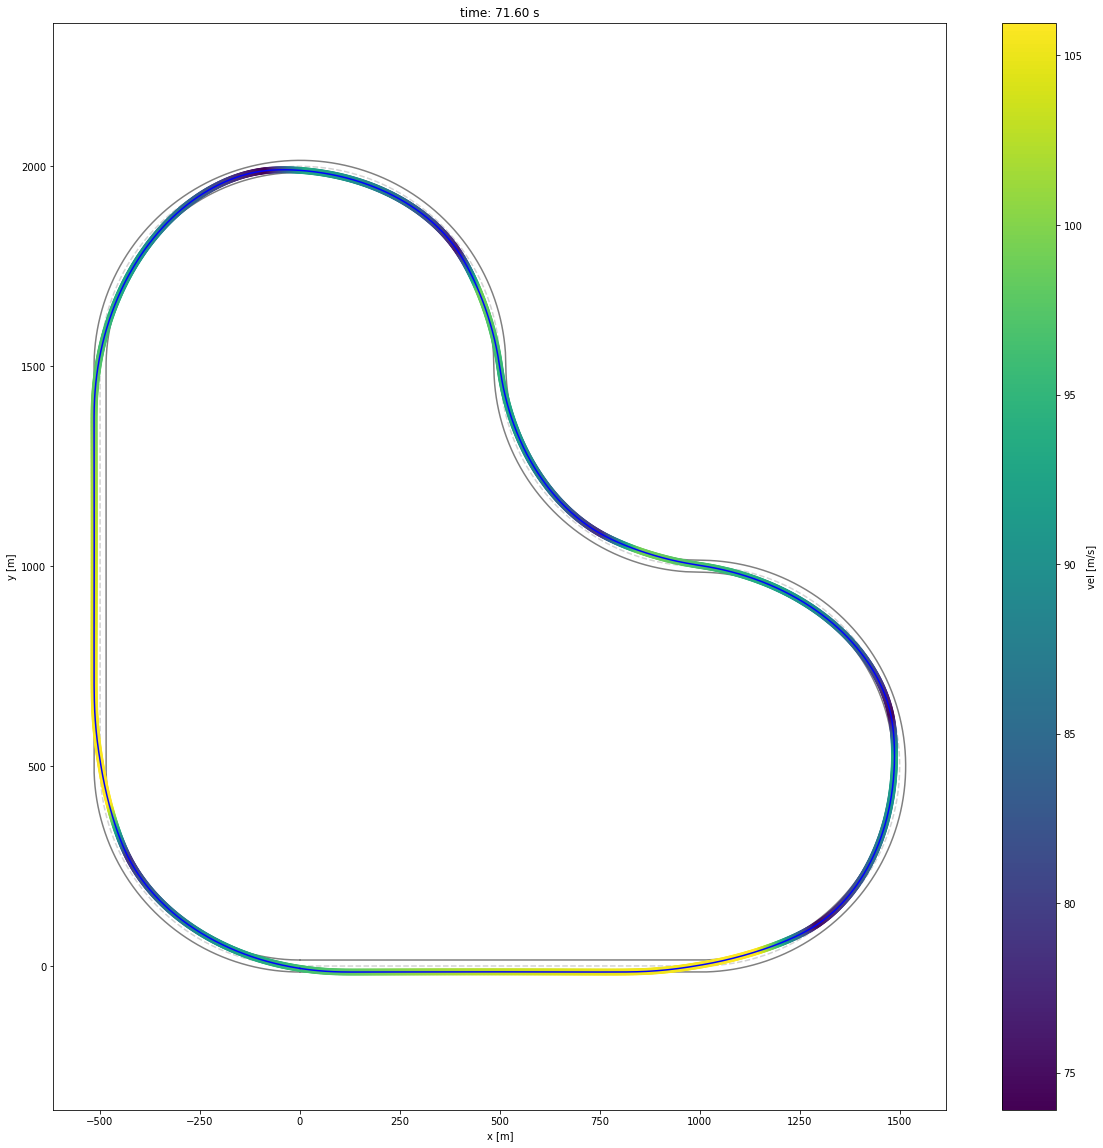

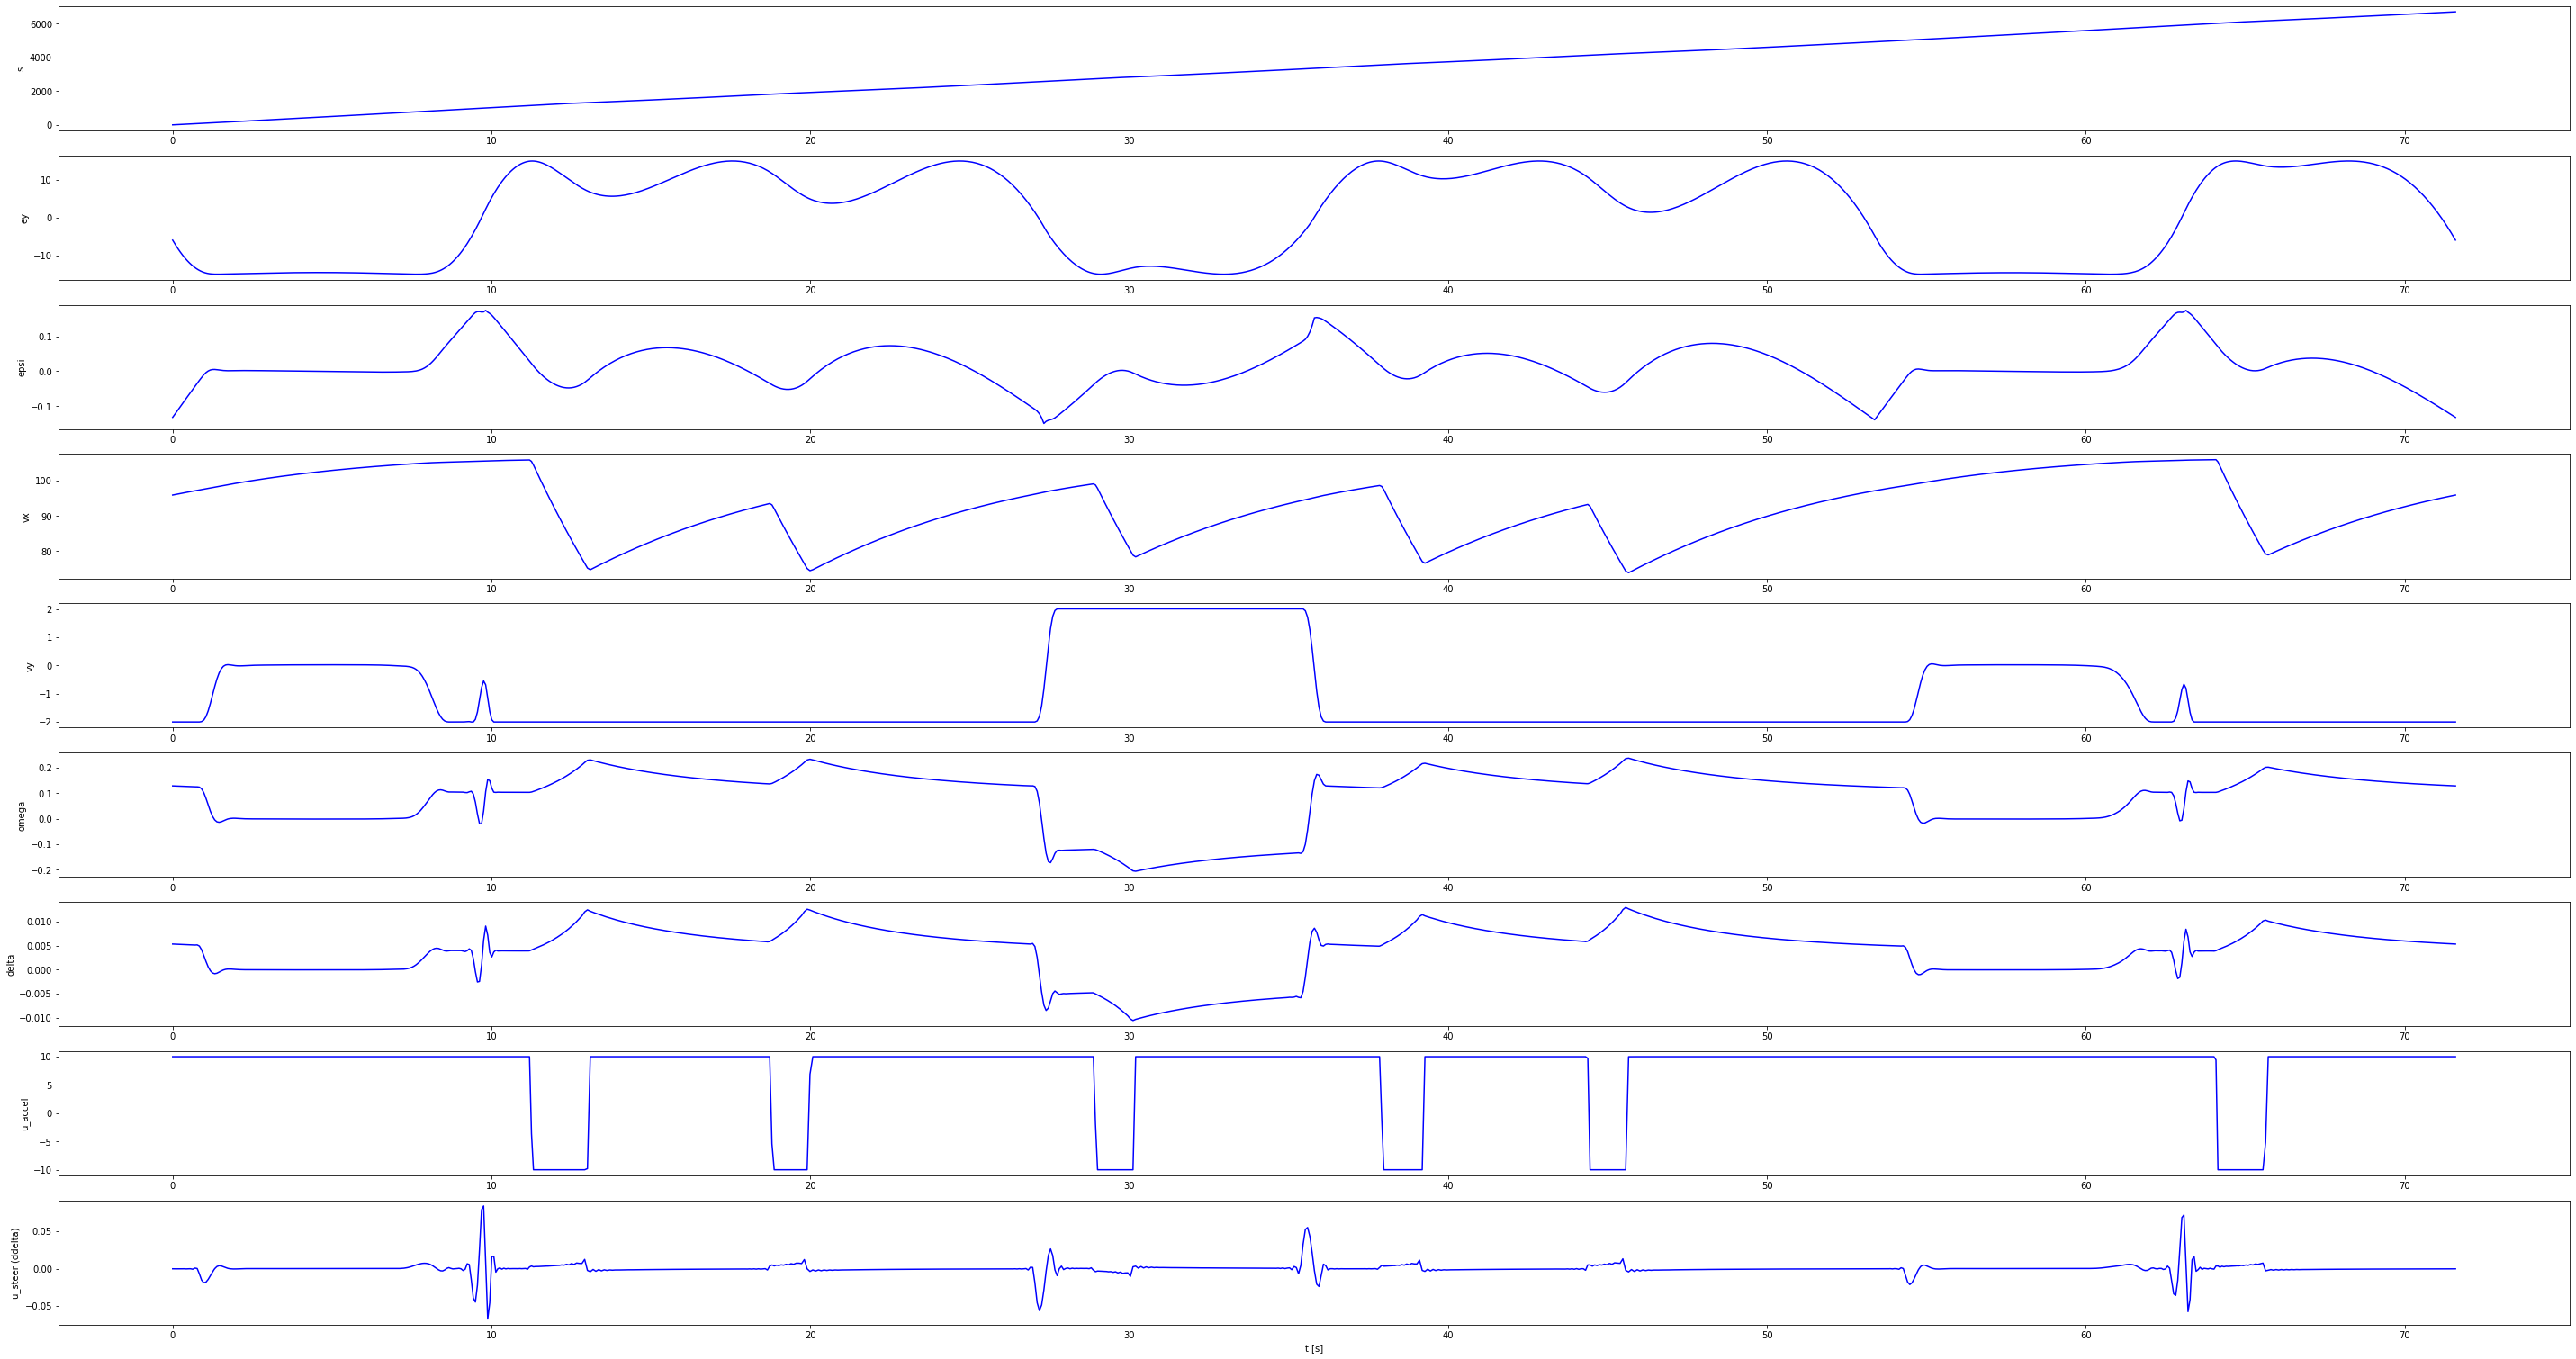

In [9]:
# Plot raceline
plot_racelines(L_track, L_raceline)

# Save raceline
filename = 'L_raceline.npz'
np.savez(filename, **L_raceline)

# Oval Track Optimization

In [11]:
# Set up oval track for optimization
oval_veh_config = get_vehicle_config()
oval_scene_config = get_scene_config(track_type=OVAL_TRACK)
oval_veh_constraints = get_vehicle_opt_constraints(oval_veh_config, oval_scene_config)
oval_track = oval_scene_config["track"]

Track Closure Error [-3.75029600e-03 -3.92672138e-01  7.42308106e-08]


In [12]:
print(oval_track.name)

OVAL w/Straight 1000, Curve Radius 250


In [13]:
oval_raceline, oval_model = compute_raceline(oval_track, oval_veh_config, oval_veh_constraints)

=================== Raceline computation ===================
Track name: OVAL w/Straight 1000, Curve Radius 250
     - length: 3570.8 m
     - width: 20 m
Vehicle configuration:
     - center of mass to front axle: 2 m
     - center of mass to rear axle: 2 m
     - mass: 800 kg
     - yaw inertia: 1800 kg m^2
     - Drag Coefficient: 0.56
     - frontal area: 2 m^2
Vehicle input constraints:
     - max acceleration: 10 m/s^2
     - min acceleration: -10 m/s^2
     - max steering angle: 0.5 rad
     - min steering angle: -0.5 rad
Vehicle state constraints:
     - max longitudinal velocity: 200 m/s
     - min longitudinal velocity: 0 m/s
     - max lateral velocity: 2 m/s
     - min lateral velocity: -2 m/s
     - max yaw rate: 1 rad/s
     - min yaw rate: -1 rad/s
of finite elements specified in apply. The larger number of finite elements
will be used.
Ipopt 3.13.4: max_iter=10000


******************************************************************************
This program contains Ipop

  66  5.8939894e+01 1.04e-01 1.21e+03  -1.0 2.54e+03  -3.1 6.42e-04 7.62e-03h  1
  67  5.8971060e+01 1.04e-01 1.21e+03  -1.0 1.04e+03  -2.7 3.01e-03 8.82e-04h  1
  68  5.8972984e+01 1.04e-01 1.21e+03  -1.0 2.89e+03  -3.1 1.36e-04 5.36e-05h  1
  69  5.9348885e+01 1.03e-01 1.19e+03  -1.0 3.19e+03  -2.7 6.94e-05 1.07e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  5.9367145e+01 1.03e-01 1.19e+03  -1.0 2.99e+03  -3.2 4.29e-03 5.34e-04h  1
  71  5.9370694e+01 1.03e-01 1.19e+03  -1.0 1.42e+03  -2.8 1.13e-04 1.03e-04h  1
  72  5.9545871e+01 1.02e-01 1.19e+03  -1.0 2.92e+03  -3.3 2.66e-04 5.07e-03f  1
  73  5.9583439e+01 1.02e-01 1.19e+03  -1.0 2.80e+03  -2.8 2.51e-03 1.11e-03h  1
  74  5.9713563e+01 1.02e-01 1.18e+03  -1.0 6.01e+03  -3.3 6.70e-04 3.66e-03h  1
  75  5.9716032e+01 1.02e-01 1.18e+03  -1.0 5.99e+03  -3.8 2.98e-04 6.72e-05h  1
  76  6.0006407e+01 1.01e-01 1.17e+03  -1.0 2.64e+03  -3.4 8.89e-05 8.47e-03h  1
  77  6.0255461e+01 1.00e-01

 159  7.9852184e+01 2.79e-02 5.65e+04  -1.0 3.96e+01  -1.4 4.38e-02 1.28e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  8.0236472e+01 2.63e-02 5.33e+04  -1.0 2.16e+01  -1.0 3.89e-02 5.76e-02h  1
 161  8.1636906e+01 3.81e-02 4.21e+04  -1.0 4.77e+01  -1.5 8.49e-02 2.10e-01h  1
 162  8.1663402e+01 3.78e-02 4.19e+04  -1.0 1.71e+01  -1.0 7.40e-02 5.48e-03h  1
 163  8.2770835e+01 3.52e-02 3.26e+04  -1.0 3.22e+01  -1.5 2.30e-02 2.22e-01h  1
 164  8.2911087e+01 3.22e-02 3.15e+04  -1.0 4.36e+02  -2.0 3.80e-02 3.34e-02f  1
 165  8.3480324e+01 2.72e-02 2.66e+04  -1.0 1.40e+01  -1.6 1.00e-01 1.55e-01h  1
 166  8.3502060e+01 2.70e-02 2.64e+04  -1.0 3.28e+02  -2.0 5.85e-02 7.00e-03h  1
 167  8.4084834e+01 2.22e-02 2.17e+04  -1.0 3.46e+01  -1.6 6.16e-02 1.79e-01h  1
 168  8.4675853e+01 1.75e-02 1.70e+04  -1.0 2.90e+01  -2.1 1.81e-01 2.15e-01h  1
 169  8.4864135e+01 1.61e-02 1.57e+04  -1.0 9.32e+01  -2.6 6.24e-02 7.97e-02f  1
iter    objective    inf_pr 

 251  5.9698707e+01 2.26e+01 4.88e+04  -2.5 4.74e+03  -5.7 2.47e-02 4.49e-02h  1
 252  5.9672227e+01 1.76e+01 4.82e+04  -2.5 4.20e+03  -6.2 1.24e-02 2.21e-01h  1
 253  5.9676877e+01 1.75e+01 4.73e+04  -2.5 5.38e+03  -6.6 1.87e-02 5.04e-03h  1
 254  5.9760377e+01 1.60e+01 4.65e+04  -2.5 1.82e+03  -6.2 1.64e-02 8.49e-02h  1
 255  5.9917157e+01 1.48e+01 4.48e+04  -2.5 4.40e+03  -6.7 3.56e-02 7.96e-02h  1
 256  5.9824918e+01 1.25e+01 3.90e+04  -2.5 3.71e+03  -7.2 1.31e-01 1.52e-01h  1
 257  5.9840876e+01 1.15e+01 3.61e+04  -2.5 1.14e+03  -6.7 7.22e-02 8.42e-02h  1
 258  6.0013104e+01 9.20e+00 3.52e+04  -2.5 1.09e+03  -6.3 2.53e-02 1.97e-01h  1
 259  6.0021244e+01 7.39e+00 1.65e+04  -2.5 1.22e+03  -6.8 5.31e-01 1.97e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  5.9974560e+01 5.43e+00 1.32e+04  -2.5 1.15e+03  -6.4 2.05e-01 2.65e-01h  1
 261  6.0133674e+01 4.48e-01 8.11e+03  -2.5 8.06e+02  -6.8 3.83e-01 9.17e-01h  1
 262  5.9929706e+01 3.44e-01

Lap time: 42.128163489638155


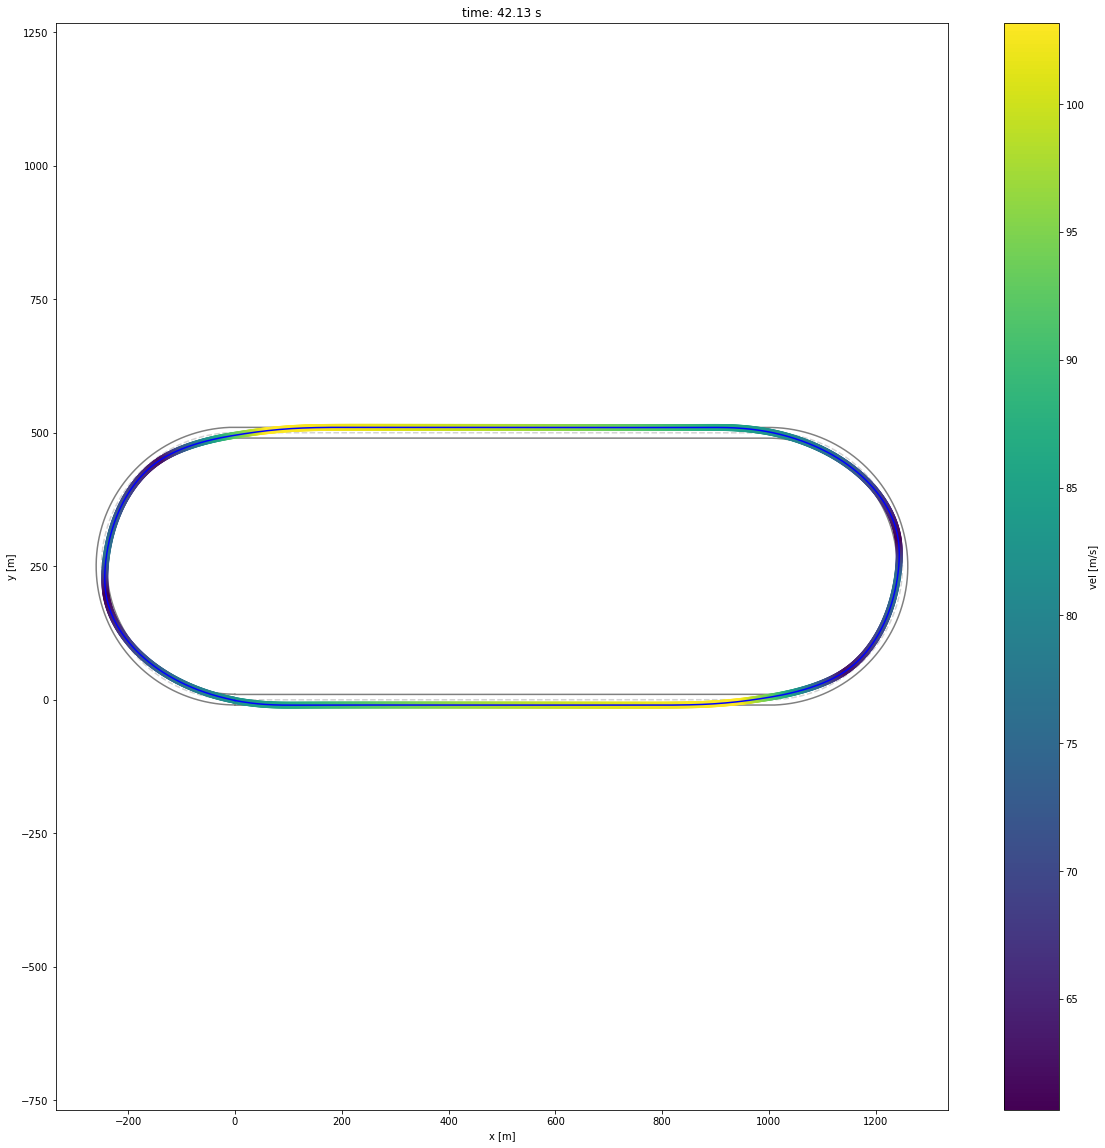

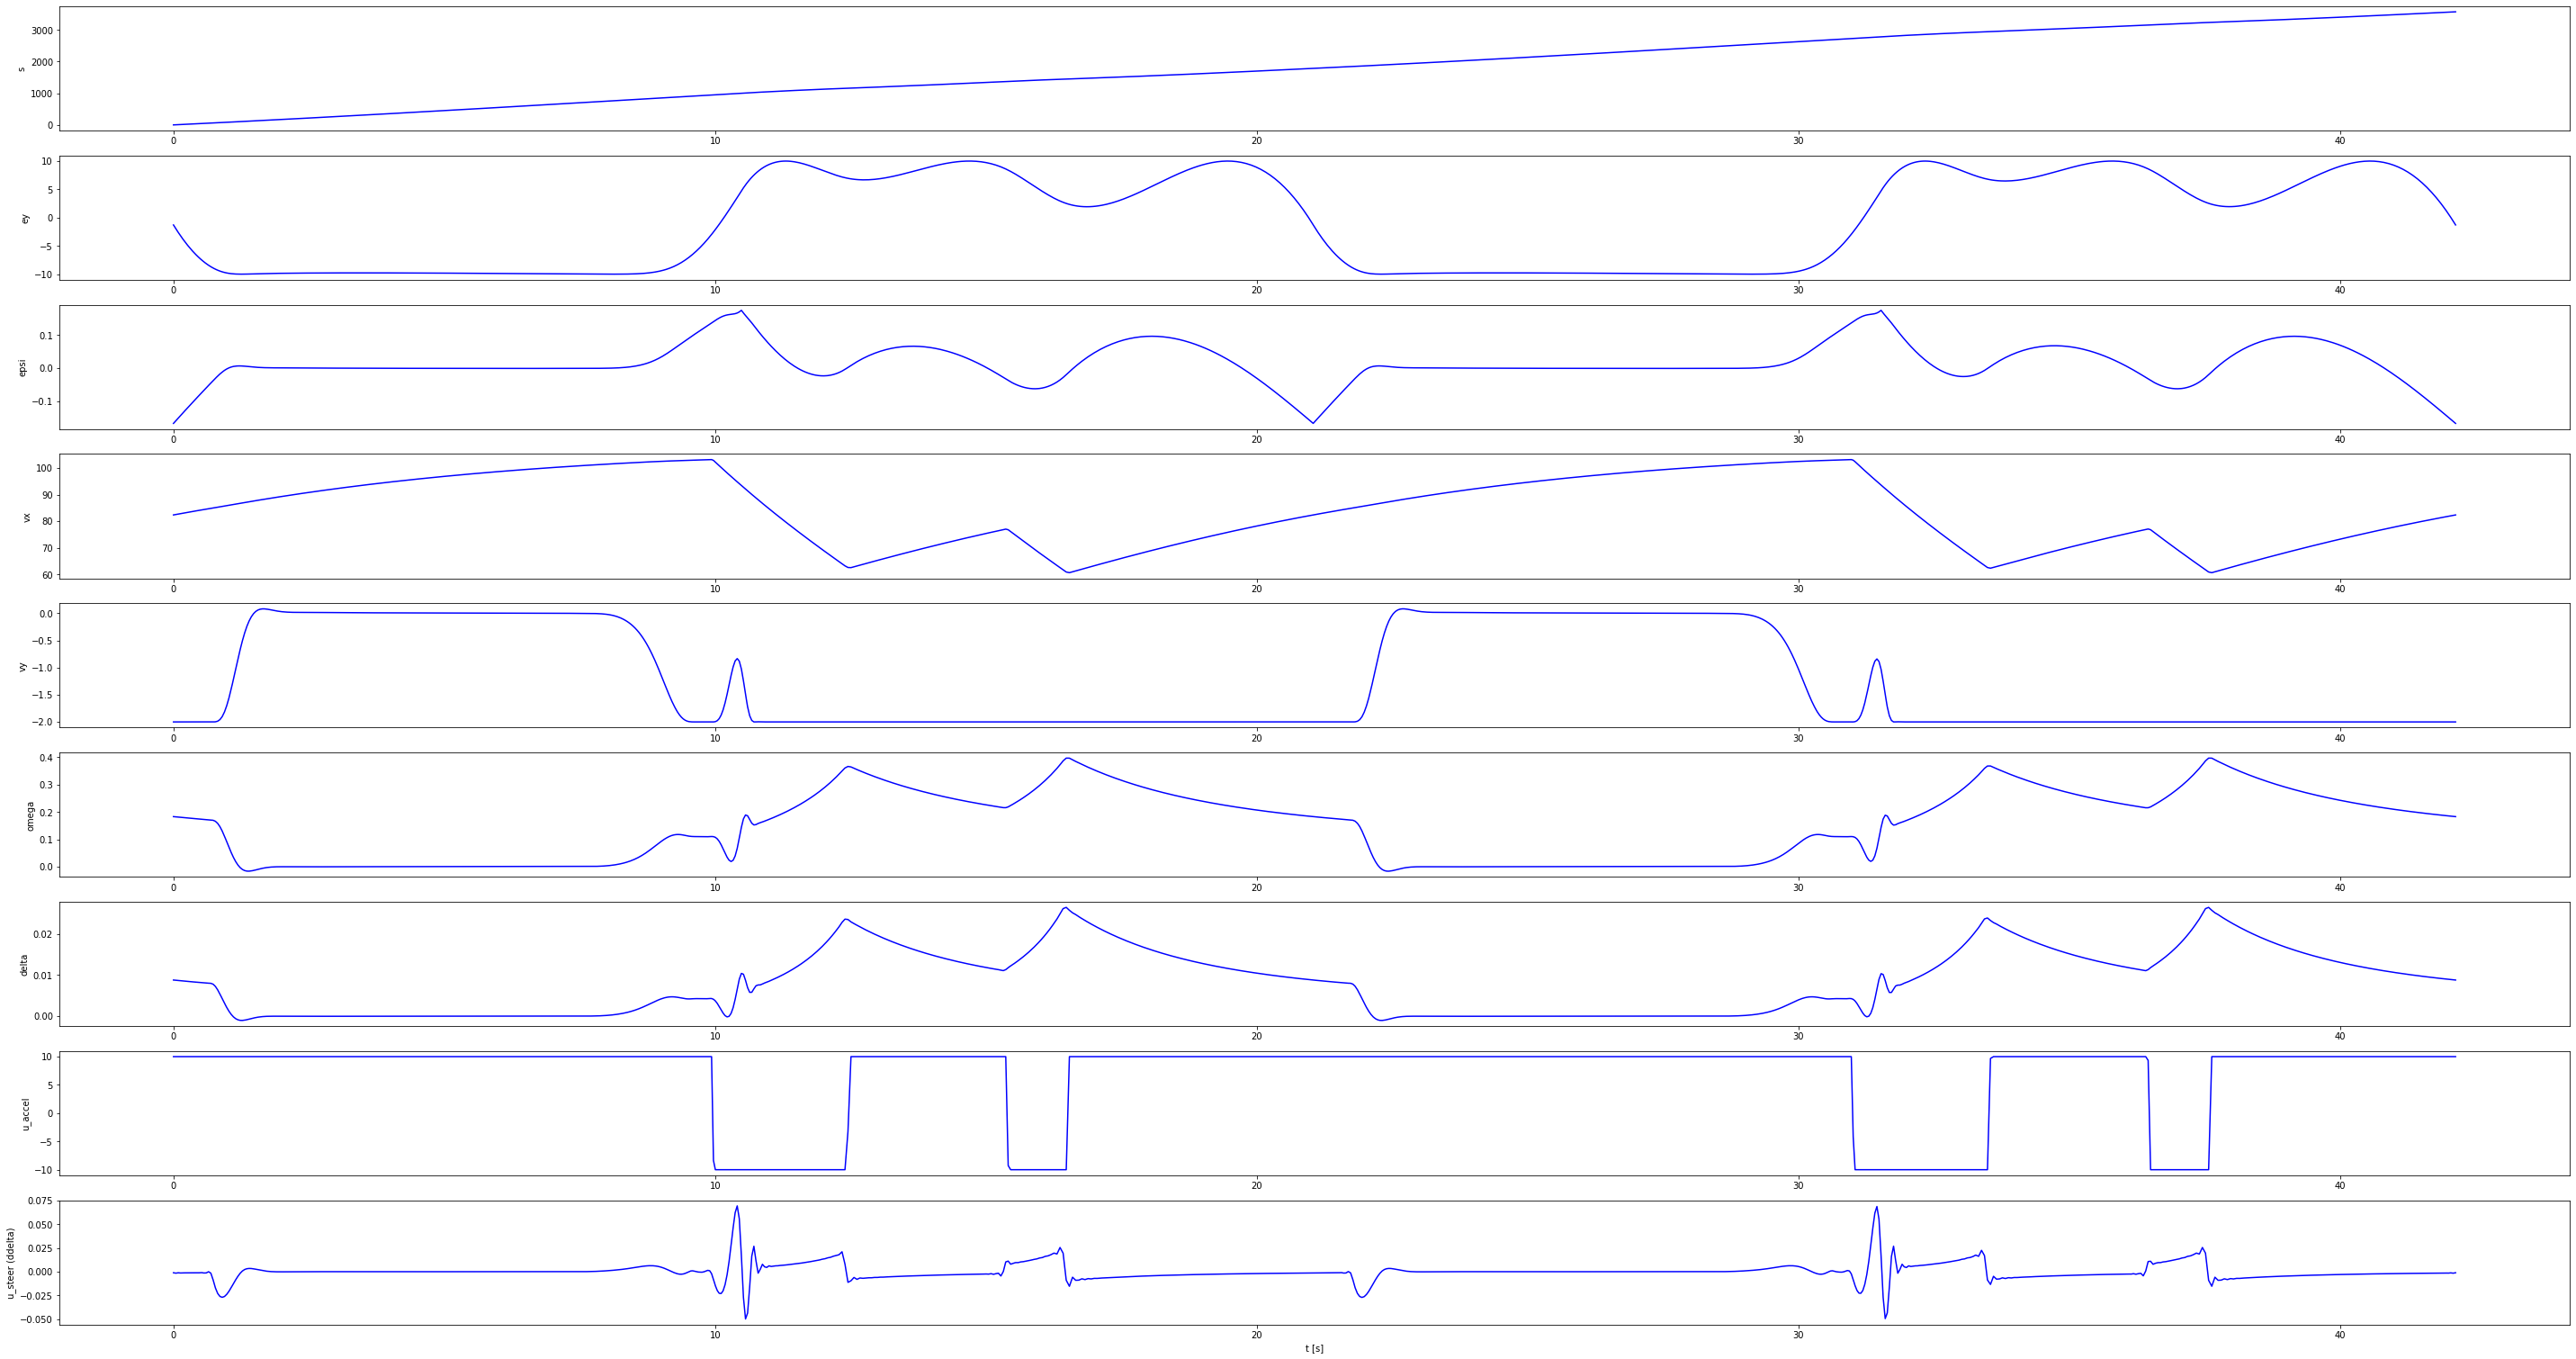

In [14]:
# Plot raceline
plot_racelines(oval_track, oval_raceline)

# Save raceline
filename = 'oval_raceline.npz'
np.savez(filename, **oval_raceline)